In [102]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
from scipy.optimize import curve_fit

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, KFold
from sklearn.metrics import r2_score

In [2]:
def plot_heatmap(heatmaps):
    
    f, axs = plt.subplots(6, 4, sharex=False, sharey=False, figsize=(18, 12))
    axr = axs.ravel()
    for i, ax in enumerate(axr):
        if i < len(heatmaps):
            sns.heatmap(heatmaps[i][1], annot=True, fmt='.2f', cmap='cividis', ax=ax)
            ax.set_xlabel('Ara')
            ax.set_ylabel('Cuma')
            ax.set_title(heatmaps[i][0])
        else:
            ax.set_visible(False)
    plt.tight_layout()
    plt.show()
    
def plot_od(ods):
    
    f, axs = plt.subplots(6, 4, sharex=False, sharey=False, figsize=(18, 12))
    axr = axs.ravel()
    for i, ax in enumerate(axr):
        if i < len(ods):
            od = ods[i]
            for col in od[1].columns:
                ax.plot(od[1].index[:45]/3, od[1][col][:45])
            #sns.heatmap(heatmaps[i][1], annot=True, fmt='.2f', cmap='cividis', ax=ax)
            ax.set_xlabel('hour')
            ax.set_ylabel('OD')
            ax.set_title(od[0])
        else:
            ax.set_visible(False)
    plt.tight_layout()
    plt.show()
    
def plot_colormesh(colormeshes):
    
    f, axs = plt.subplots(4, 8, sharex=False, sharey=False, figsize=(18, 6))
    axr = axs.ravel()
    for i, ax in enumerate(axr):
        if i < len(colormeshes):
            cf = ax.pcolormesh(colormeshes[i][0], colormeshes[i][1],
                               colormeshes[i][2].reshape(-1, colormeshes[i][3]), cmap='viridis')
            f.colorbar(cf, ax=ax)
            ax.set_xlabel('Ara')
            ax.set_ylabel('Cuma')
            ax.set_title(colormeshes[i][4])
        else:
            ax.set_visible(False)
    plt.tight_layout()
    plt.show()

def plot_heatmap(heatmaps):
    
    f, axs = plt.subplots(6, 4, sharex=False, sharey=False, figsize=(18, 12))
    axr = axs.ravel()
    for i, ax in enumerate(axr):
        if i < len(heatmaps):
            sns.heatmap(heatmaps[i][1], annot=True, fmt='.2f', cmap='cividis', ax=ax)
            ax.set_xlabel('Ara')
            ax.set_ylabel('Cuma')
            ax.set_title(heatmaps[i][0])
        else:
            ax.set_visible(False)
    plt.tight_layout()
    plt.show()
    
def plot_od(ods):
    
    f, axs = plt.subplots(6, 4, sharex=False, sharey=False, figsize=(18, 12))
    axr = axs.ravel()
    for i, ax in enumerate(axr):
        if i < len(ods):
            od = ods[i]
            for col in od[1].columns:
                ax.plot(od[1].index[:45]/3, od[1][col][:45])
            #sns.heatmap(heatmaps[i][1], annot=True, fmt='.2f', cmap='cividis', ax=ax)
            ax.set_xlabel('hour')
            ax.set_ylabel('OD')
            ax.set_title(od[0])
        else:
            ax.set_visible(False)
    plt.tight_layout()
    plt.show()
    
def plot_colormesh(colormeshes):
    
    f, axs = plt.subplots(4, 8, sharex=False, sharey=False, figsize=(18, 6))
    axr = axs.ravel()
    for i, ax in enumerate(axr):
        if i < len(colormeshes):
            cf = ax.pcolormesh(colormeshes[i][0], colormeshes[i][1],
                               colormeshes[i][2].reshape(-1, colormeshes[i][3]), cmap='viridis')
            f.colorbar(cf, ax=ax)
            ax.set_xlabel('Ara')
            ax.set_ylabel('Cuma')
            ax.set_title(colormeshes[i][4])
        else:
            ax.set_visible(False)
    plt.tight_layout()
    plt.show()

In [3]:
def generate_metadata(well, plate_map):
    
    sample_map = {
        'BS': 'blank-spec',
        'BK': 'blank-kan',
        'NS': 'negative-control-spec',
        'NK': 'negative-control-kan',
        'J100-GFP': 'positive-control-kan'
    }
    df = pd.merge(raw_data['Well'], plate_map, on='Well', how='left').reset_index(drop=True)
    df['short_name'] = df['value'].map(sample_map) + '_' + df['suffix'].astype(str)
    df.loc[df['short_name'].isnull(), 'short_name'] = df['value'] + '_' + df['suffix'].astype(str)
    return df.dropna()

def transpose_data(df, col):
    
    df.set_index(col, inplace=True)
    df = df.transpose().reset_index()
    df = df.set_index('index')
    return df

def generate_data(df, name, datapoint=2, num_data=4, start_idx=3, col='short_name'):
    
    datas = []
    idxs = [start_idx]
    for i in range(1, num_data+1):
        idxs.append(idxs[i-1] + datapoint)
        data = (df.iloc[:, idxs[i-1]:idxs[i]]).astype(float)
        data = pd.concat([name, data], axis=1)
        data = transpose_data(data, col)
        datas.append(data)
    return datas

def get_blank_corrected(data):
    
    blank_corrected = data.sub(data[filter(lambda x: x.startswith('blank'), data.columns)].mean(axis=1), axis=0)
    return blank_corrected.drop(filter(lambda x: x.startswith('blank'), blank_corrected.columns), axis=1).reset_index(drop=True)

def get_neg_ctrl_corrected(fluo, od):
    
    blank_corr_fluo = get_blank_corrected(fluo)
    blank_corr_od = get_blank_corrected(od)
    blank_corr_od = blank_corr_od.replace(0, 1e-5)
    data = blank_corr_fluo / blank_corr_od
    neg_corrected = data.sub(data[filter(lambda x: x.startswith('negative-control'), data.columns)].mean(axis=1), axis=0)
    return neg_corrected.drop(filter(lambda x: x.startswith('negative-control'), neg_corrected.columns), axis=1)

In [4]:
folder = '039-3i-AND-gates'

In [5]:
def read_map(plate_map):
    
    plate_map = plate_map.melt(id_vars=['group'])
    plate_map['variable'] = plate_map['variable'].astype(int)
    plate_map['Well'] = plate_map['group'] + plate_map['variable'].apply(lambda x: '{:02d}'.format(x))
    plate_map['suffix'] = plate_map['group'].apply(lambda x: str(ord(x)- 65))
    return plate_map[['Well', 'value', 'suffix']].dropna()

In [6]:
plate_map = read_map(pd.read_csv('datasets/experiment/{}/plate_map.csv'.format(folder)))
raw_data = pd.read_csv('datasets/experiment/{}/raw.csv'.format(folder), skiprows=[0])
metadata = generate_metadata(raw_data['Well'], plate_map)
data = raw_data[raw_data['Well'].isin(metadata['Well'])].reset_index(drop=True)
datas = generate_data(data, metadata['short_name'], datapoint=int((raw_data.shape[1] - 3)/4))

In [7]:
samples = get_neg_ctrl_corrected(datas[3][filter(lambda x: '-kan' not in x, datas[3].columns)],
                                 datas[0][filter(lambda x: '-kan' not in x, datas[0].columns)])
reporter = get_neg_ctrl_corrected(datas[3][filter(lambda x: '-kan' in x, datas[3].columns)],
                              datas[0][filter(lambda x: '-kan' in x, datas[0].columns)])

In [8]:
h = 12
timepoint = 3 * h
samples_t = samples.iloc[timepoint]
reporter_t = reporter.iloc[timepoint]

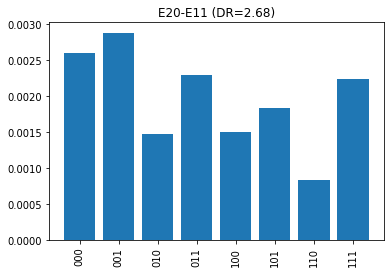

In [11]:
gate = 'E20-E11'
x = [format(x, '0{}b'.format(3)) for x in list(range(2**3))]
y = samples_t[filter(lambda x: x.startswith(gate), samples_t.index)]/np.mean(reporter_t)
dr = y.iloc[7]/y.iloc[6]
plt.bar(x, y)
plt.xticks(rotation=90)
plt.title('{} (DR={})'.format(gate, np.round(dr, 2)))
plt.show()

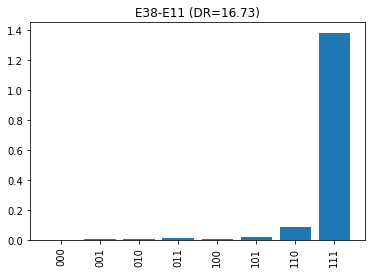

In [12]:
gate = 'E38-E11'
x = [format(x, '0{}b'.format(3)) for x in list(range(2**3))]
y = samples_t[filter(lambda x: x.startswith(gate), samples_t.index)]/np.mean(reporter_t)
dr = y.iloc[7]/y.iloc[6]
plt.bar(x, y)
plt.xticks(rotation=90)
plt.title('{} (DR={})'.format(gate, np.round(dr, 2)))
plt.show()

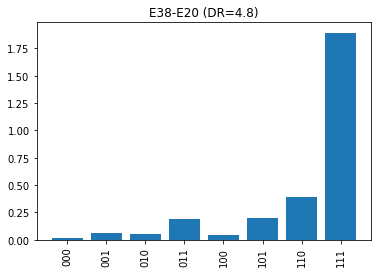

In [9]:
gate = 'E38-E20'
x = [format(x, '0{}b'.format(3)) for x in list(range(2**3))]
y = samples_t[filter(lambda x: x.startswith(gate), samples_t.index)]/np.mean(reporter_t)
dr = y.iloc[7]/y.iloc[6]
plt.bar(x, y)
plt.xticks(rotation=90)
plt.title('{} (DR={})'.format(gate, np.round(dr, 2)))
plt.show()

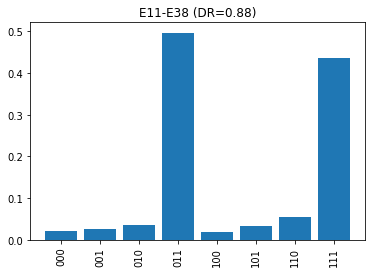

In [10]:
gate = 'E11-E38'
x = [format(x, '0{}b'.format(3)) for x in list(range(2**3))]
y = samples_t[filter(lambda x: x.startswith(gate), samples_t.index)]/np.mean(reporter_t)
dr = y.iloc[7]/y.iloc[3]
plt.bar(x, y)
plt.xticks(rotation=90)
plt.title('{} (DR={})'.format(gate, np.round(dr, 2)))
plt.show()

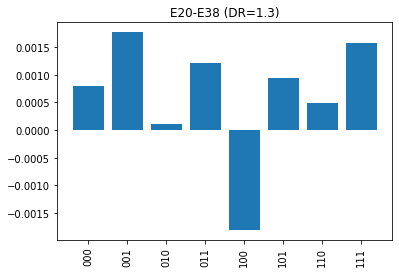

In [13]:
gate = 'E20-E38'
x = [format(x, '0{}b'.format(3)) for x in list(range(2**3))]
y = samples_t[filter(lambda x: x.startswith(gate), samples_t.index)]/np.mean(reporter_t)
dr = y.iloc[7]/y.iloc[3]
plt.bar(x, y)
plt.xticks(rotation=90)
plt.title('{} (DR={})'.format(gate, np.round(dr, 2)))
plt.show()

In [76]:
folder = '040-3i-AND-gates-induction-matrix-rep1'

def read_map(plate_map):
    
    plate_map = plate_map.melt(id_vars=['group'])
    plate_map['variable'] = plate_map['variable'].astype(int)
    plate_map['Well'] = plate_map['group'] + plate_map['variable'].apply(lambda x: '{:02d}'.format(x))
    plate_map['suffix'] = plate_map['group'].apply(lambda x: str(ord(x)- 65))
    return plate_map[['Well', 'value', 'suffix']].dropna()

plate_map = read_map(pd.read_csv('datasets/experiment/{}/plate_map.csv'.format(folder)))
raw_data = pd.read_csv('datasets/experiment/{}/raw.csv'.format(folder), skiprows=[0])
metadata = generate_metadata(raw_data['Well'], plate_map).reset_index(drop=True)
data = raw_data[raw_data['Well'].isin(metadata['Well'])].reset_index(drop=True)
datas = generate_data(data, metadata['short_name'], datapoint=int((raw_data.shape[1] - 3)/4))

In [40]:
samples = get_neg_ctrl_corrected(datas[3][filter(lambda x: '-kan' not in x, datas[3].columns)],
                                 datas[0][filter(lambda x: '-kan' not in x, datas[0].columns)])
reporter = get_neg_ctrl_corrected(datas[3][filter(lambda x: '-kan' in x, datas[3].columns)],
                              datas[0][filter(lambda x: '-kan' in x, datas[0].columns)])

In [41]:
h = 12
timepoint = 3 * h
samples_t = samples.iloc[timepoint]
reporter_t = reporter.iloc[timepoint]

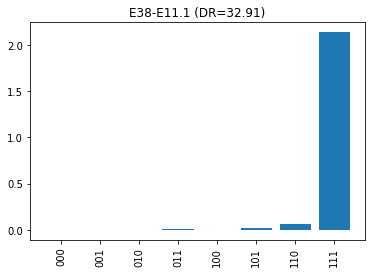

In [43]:
gate = 'E38-E11.1'
x = [format(x, '0{}b'.format(3)) for x in list(range(2**3))]
y = samples_t[filter(lambda x: x.startswith(gate), samples_t.index)]/np.mean(reporter_t)
dr = y.iloc[7]/y.iloc[6]
plt.bar(x, y)
plt.xticks(rotation=90)
plt.title('{} (DR={})'.format(gate, np.round(dr, 2)))
plt.show()

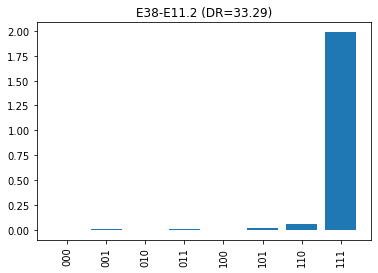

In [44]:
gate = 'E38-E11.2'
x = [format(x, '0{}b'.format(3)) for x in list(range(2**3))]
y = samples_t[filter(lambda x: x.startswith(gate), samples_t.index)]/np.mean(reporter_t)
dr = y.iloc[7]/y.iloc[6]
plt.bar(x, y)
plt.xticks(rotation=90)
plt.title('{} (DR={})'.format(gate, np.round(dr, 2)))
plt.show()

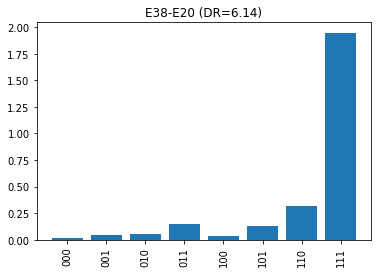

In [45]:
gate = 'E38-E20'
x = [format(x, '0{}b'.format(3)) for x in list(range(2**3))]
y = samples_t[filter(lambda x: x.startswith(gate), samples_t.index)]/np.mean(reporter_t)
dr = y.iloc[7]/y.iloc[6]
plt.bar(x, y)
plt.xticks(rotation=90)
plt.title('{} (DR={})'.format(gate, np.round(dr, 2)))
plt.show()

In [46]:
folder = '041-3i-AND-gates-induction-matrix-rep2'
plate_map = read_map(pd.read_csv('datasets/experiment/{}/plate_map.csv'.format(folder)))
raw_data = pd.read_csv('datasets/experiment/{}/raw.csv'.format(folder), skiprows=[0])
metadata = generate_metadata(raw_data['Well'], plate_map).reset_index(drop=True)
data = raw_data[raw_data['Well'].isin(metadata['Well'])].reset_index(drop=True)
datas = generate_data(data, metadata['short_name'], datapoint=int((raw_data.shape[1] - 3)/4))

In [47]:
samples = get_neg_ctrl_corrected(datas[3][filter(lambda x: '-kan' not in x, datas[3].columns)],
                                 datas[0][filter(lambda x: '-kan' not in x, datas[0].columns)])
reporter = get_neg_ctrl_corrected(datas[3][filter(lambda x: '-kan' in x, datas[3].columns)],
                              datas[0][filter(lambda x: '-kan' in x, datas[0].columns)])

In [48]:
h = 12
timepoint = 3 * h
samples_t = samples.iloc[timepoint]
reporter_t = reporter.iloc[timepoint]

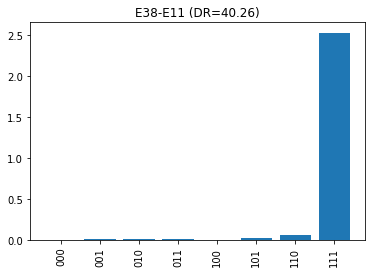

In [49]:
gate = 'E38-E11'
x = [format(x, '0{}b'.format(3)) for x in list(range(2**3))]
y = samples_t[filter(lambda x: x.startswith(gate), samples_t.index)]/np.mean(reporter_t)
dr = y.iloc[7]/y.iloc[6]
plt.bar(x, y)
plt.xticks(rotation=90)
plt.title('{} (DR={})'.format(gate, np.round(dr, 2)))
plt.show()

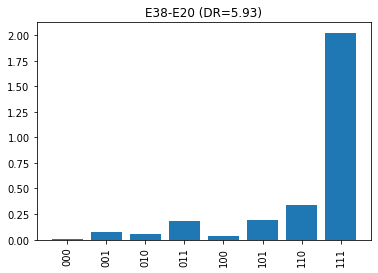

In [50]:
gate = 'E38-E20'
x = [format(x, '0{}b'.format(3)) for x in list(range(2**3))]
y = samples_t[filter(lambda x: x.startswith(gate), samples_t.index)]/np.mean(reporter_t)
dr = y.iloc[7]/y.iloc[6]
plt.bar(x, y)
plt.xticks(rotation=90)
plt.title('{} (DR={})'.format(gate, np.round(dr, 2)))
plt.show()

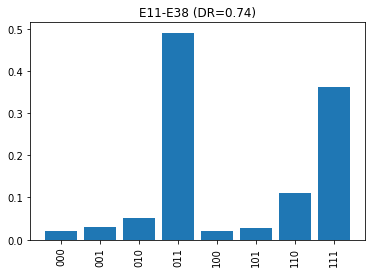

In [51]:
gate = 'E11-E38'
x = [format(x, '0{}b'.format(3)) for x in list(range(2**3))]
y = samples_t[filter(lambda x: x.startswith(gate), samples_t.index)]/np.mean(reporter_t)
dr = y.iloc[7]/y.iloc[3]
plt.bar(x, y)
plt.xticks(rotation=90)
plt.title('{} (DR={})'.format(gate, np.round(dr, 2)))
plt.show()

#### Induction Matrix

In [78]:
folder = '041-3i-AND-gates-induction-matrix-rep2'

def read_map(plate_map):
    
    plate_map = plate_map.melt(id_vars=['group'])
    plate_map['variable'] = plate_map['variable'].astype(int)
    plate_map['Well'] = plate_map['group'] + plate_map['variable'].apply(lambda x: '{:02d}'.format(x))
    induction_states = []
    for i in range(4):
        for j in range(4):
            for k in range(4):
                induction_states.append(str(i) + str(j) + str(k))
    
    plate_map = plate_map[['Well', 'value']].dropna()
    plate_map['suffix'] = induction_states
    return plate_map

plate_map = read_map(pd.read_csv('datasets/experiment/{}/plate_map_induction.csv'.format(folder)))
raw_data = pd.read_csv('datasets/experiment/{}/raw.csv'.format(folder), skiprows=[0])
metadata = generate_metadata(raw_data['Well'], plate_map).reset_index(drop=True)
data = raw_data[raw_data['Well'].isin(metadata['Well'])].reset_index(drop=True)
datas = generate_data(data, metadata['short_name'], datapoint=int((raw_data.shape[1] - 3)/4))

In [96]:
ctrl_metadata = ['blank-spec', 'negative-control-spec_1', 'negative-control-spec_2',
       'blank-kan', 'negative-control-kan_1', 'negative-control-kan_2', 'positive-control-kan_1', 'positive-control-kan_2']
ctrl = raw_data[raw_data['Well'].str.contains('12')].reset_index(drop=True)
ctrl_datas = generate_data(ctrl, pd.Series(ctrl_metadata, name='short_name'), datapoint=int((raw_data.shape[1] - 3)/4))

In [97]:
combined_datas = []
for i in range(len(datas)):
    combined_datas.append(pd.concat([datas[i], ctrl_datas[i]], axis=1))

In [98]:
samples = get_neg_ctrl_corrected(combined_datas[3][filter(lambda x: '-kan' not in x, combined_datas[3].columns)],
                                 combined_datas[0][filter(lambda x: '-kan' not in x, combined_datas[0].columns)])
reporter = get_neg_ctrl_corrected(combined_datas[3][filter(lambda x: '-kan' in x, combined_datas[3].columns)],
                              combined_datas[0][filter(lambda x: '-kan' in x, combined_datas[0].columns)])

In [100]:
h = 12
timepoint = 3 * h
samples_t = samples.iloc[timepoint]
reporter_t = reporter.iloc[timepoint]

In [105]:
ara = [0, 0.8125, 3.25, 13]
ohc14 = [0, 2.5, 5, 10]
sal = [0, 25, 50, 100]
data = samples_t.reset_index()
data['ara'] = data['short_name'].apply(lambda x: ara[int(x[-3])])
data['ohc14'] = data['short_name'].apply(lambda x: ohc14[int(x[-2])])
data['sal'] = data['short_name'].apply(lambda x: sal[int(x[-1])])
X = data[['ara', 'ohc14', 'sal']]
y = data[timepoint]

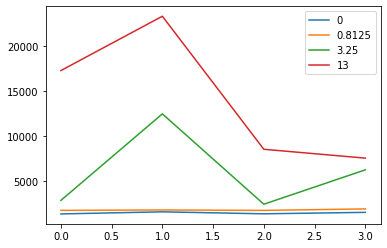

In [133]:
sal_lvl = sal[0]
for ara_lvl in ara:
    ohc_data = data[(data['ara']==ara_lvl) & (data['sal']==sal_lvl)]
    plt.plot(np.arange(0, len(sal)), ohc_data[36], label=ara_lvl)
plt.legend()
plt.show()

In [118]:
sal_data

,short_name,36,ara,ohc14,sal
33,E11-E38_030,1515.957731,0.0,10.0,0
41,E11-E38_031,7224.343927,0.0,10.0,25
49,E11-E38_032,1560.698791,0.0,10.0,50
57,E11-E38_033,6511.861745,0.0,10.0,100


In [135]:
data.sort_values('short_name')

,short_name,36,ara,ohc14,sal
0,E11-E38_000,1342.961613,0.0000,0.0,0
8,E11-E38_001,2834.171191,0.0000,0.0,25
16,E11-E38_002,1390.161986,0.0000,0.0,50
24,E11-E38_003,6452.920836,0.0000,0.0,100
32,E11-E38_010,1354.971877,0.0000,2.5,0
40,E11-E38_011,2651.724257,0.0000,2.5,25
48,E11-E38_012,1348.293590,0.0000,2.5,50
56,E11-E38_013,2347.670245,0.0000,2.5,100
1,E11-E38_020,1574.509802,0.0000,5.0,0
9,E11-E38_021,12231.441602,0.0000,5.0,25
